In [2]:
from typing import List, Dict, Union, Optional, Tuple

In [3]:
import qiskit as qk
import qiskit.quantum_info as qi
import qiskit.circuit as qc
from qiskit.providers import aer

In [4]:
from math import pi, log2, log10
from random import random

In [5]:
import numpy as np

In [6]:
from ray.util.multiprocessing import Pool
import ray
try:
    pool
except NameError:
    ray.shutdown()
    ray.init()
    pool = Pool()

2020-04-25 13:24:21,411	INFO resource_spec.py:204 -- Starting Ray with 258.54 GiB memory available for workers and up to 114.81 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-25 13:24:22,801	INFO services.py:1146 -- View the Ray dashboard at localhost:8265
2020-04-25 13:24:33,117	WARNING worker.py:1072 -- The actor or task with ID ffffffffffffffff45b95b1c0100 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {node:131.111.20.225: 1.000000}, {CPU: 144.000000}, {memory: 258.544922 GiB}, {object_store_memory: 79.199219 GiB}. In total there are 0 pending tasks and 144 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster

# Utilities

In [7]:
def ilog2(x) -> int:
    return int(log2(x))
def arr_qubits(x: np.array):
    return ilog2(len(x))

In [8]:
def rand2pi() -> float:
    return random() * 2 * pi

In [9]:
rand2pi()

2.8651238059207307

In [10]:
iYgate=qk.extensions.UnitaryGate(data=[[0, 1.j], [-1.j, 0]])
ciYgate=iYgate.control(label="iY")

In [11]:
def unique_param(prefix: str = "$") -> qc.Parameter:
    unique_param.counter += 1
    return qc.Parameter(f"{prefix}{unique_param.counter}")
unique_param.counter = 0

In [12]:
unique_param()

Parameter($1)

We adopt the convention that parameters that start with dollar are going to be initialized uniformly at random from [0, 2pi], and those with dollardollar are set to zero.

In [13]:
def rand_for_param(param: qc.Parameter) -> float:
    if param.name[:2] == "00":
        return 0.
    else:
        return rand2pi()

# Variational Forms

In [14]:
def new_circuit(width: int) -> qc.QuantumCircuit:
    circ = qc.QuantumCircuit(width)
    return circ
def empty_circuit_like(circ: qc.QuantumCircuit) -> qc.QuantumCircuit:
    return qc.QuantumCircuit(*circ.qregs, *circ.cregs)

## Unitary Layer

In [15]:
def unitary_layer(width: int) -> qc.QuantumCircuit:
    circ = new_circuit(width)
    for qubit in circ.qubits:
        circ.ry(unique_param(), qubit)
    return circ

In [16]:
unitary_layer(3).draw()

┌────────┐
q_0: ┤ Ry($2) ├
     ├────────┤
q_1: ┤ Ry($3) ├
     ├────────┤
q_2: ┤ Ry($4) ├
     └────────┘

## Entangling Layer

We don't by default assume extreme entanglement is useful; as such, we allow a parametrized z rotation.

In [17]:
def entangling_layer(width: int, offset: int)-> qc.QuantumCircuit:
    circ = qc.QuantumCircuit(width)
    for i in range(0, circ.num_qubits-1, 2):
        idx_a = (i+offset) % circ.num_qubits
        idx_b = (i+1+offset) % circ.num_qubits
        circ.crz(unique_param("$$"), idx_a, idx_b)
    return circ

In [18]:
entangling_layer(12, 1).draw()

┌──────────┐
 q_0: ───────────┤ Rz($$10) ├
                 └────┬─────┘
 q_1: ─────■──────────┼──────
      ┌────┴────┐     │      
 q_2: ┤ Rz($$5) ├─────┼──────
      └─────────┘     │      
 q_3: ─────■──────────┼──────
      ┌────┴────┐     │      
 q_4: ┤ Rz($$6) ├─────┼──────
      └─────────┘     │      
 q_5: ─────■──────────┼──────
      ┌────┴────┐     │      
 q_6: ┤ Rz($$7) ├─────┼──────
      └─────────┘     │      
 q_7: ─────■──────────┼──────
      ┌────┴────┐     │      
 q_8: ┤ Rz($$8) ├─────┼──────
      └─────────┘     │      
 q_9: ─────■──────────┼──────
      ┌────┴────┐     │      
q_10: ┤ Rz($$9) ├─────┼──────
      └─────────┘     │      
q_11: ────────────────■──────

In [19]:
(unitary_layer(4) + entangling_layer(4, 0)).draw()

┌─────────┐            
q_0: ┤ Ry($11) ├─────■──────
     ├─────────┤┌────┴─────┐
q_1: ┤ Ry($12) ├┤ Rz($$15) ├
     ├─────────┤└──────────┘
q_2: ┤ Ry($13) ├─────■──────
     ├─────────┤┌────┴─────┐
q_3: ┤ Ry($14) ├┤ Rz($$16) ├
     └─────────┘└──────────┘

## Postselection Gadget Layer

This is a simple RUS circuit from arxiv.org/abs/1711.11240.
As this is a RUS circuit, the postselection can be done efficiently.

In [60]:
qc.gate

<module 'qiskit' from '/home/jkrb2/opt/anaconda3/envs/rvqe/lib/python3.8/site-packages/qiskit/__init__.py'>

In [57]:
PSGADGET_ANCILLA_QREG = qc.QuantumRegister(1, "q_{ps}")
PSGADGET_ANCILLA_CREG = qc.ClassicalRegister(1, "c_{ps}")

def postsel_gadget_layer(width: int, inlanes: List[int], outlane: int, add_measurement: bool = False) -> qc.QuantumCircuit:    
    circ = new_circuit(width)
    circ.add_register(PSGADGET_ANCILLA_QREG)
    
    params = [ unique_param() for _ in inlanes ]
    
    # always apply (static) correction before RUS circuit so that we can simply repeat it
    if add_measurement:
        circ.rz(-pi/2, circ.qubits[outlane])
    
    # RUS circuit
    for i, lane in enumerate(inlanes):
        circ.cry(params[i], circ.qubits[lane], PSGADGET_ANCILLA_QREG[0])
    circ.cy(PSGADGET_ANCILLA_QREG[0], circ.qubits[outlane])
    circ.rz(-pi/2, PSGADGET_ANCILLA_QREG[0])
    for i, lane in reversed(list((enumerate(inlanes)))):
        circ.cry(-params[i], circ.qubits[lane], PSGADGET_ANCILLA_QREG[0])
        
    # measurement
    if add_measurement:
        circ.add_register(PSGADGET_ANCILLA_CREG)
        circ.measure(PSGADGET_ANCILLA_QREG[0], PSGADGET_ANCILLA_CREG[0])
    
    return circ

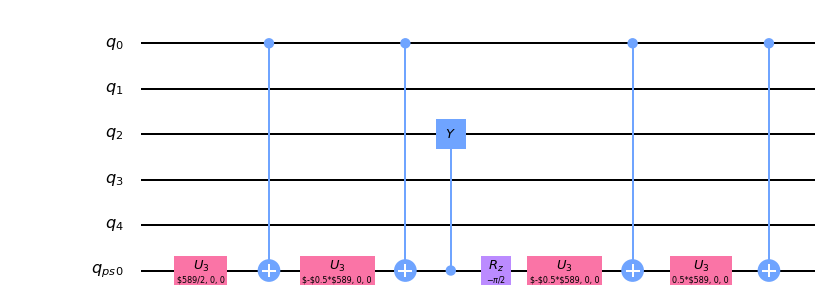

In [59]:
postsel_gadget_layer(5, [0], 2, add_measurement=False).draw(output="mpl")

In [22]:
def postselect(psi: qi.Statevector, qubit_idx: int, what: int = 0, flip_threshold: float = 1e-8) -> qi.Statevector:
    """
        postselect on a measurement outcome;
        if postselection_probability is below the threshold, we postselect on the complement
    """
    qubit_idx %= psi.num_qubits
    
    p = psi.probabilities([qubit_idx])
    
    if p[what] < flip_threshold:
        what = 1-what
    
    proj = np.zeros(2, dtype=complex)
    proj[what] = 1 / np.sqrt(p[what])
    
    return psi.evolve(qi.Operator(np.diag(proj), input_dims=2, output_dims=2), qargs=[qubit_idx])

def postselect_multi(psi: qi.Statevector, qubit_indices: List[int], whats: List[int], flip_threshold: float = 1e-8) -> qi.Statevector:
    """
        postselect on multiple outcomes
    """
    assert len(qubit_indices) == len(whats), "indices count and targets have to be same size"
    
    for idx, what in zip(qubit_indices, whats):
        psi = postselect(psi, idx, what, flip_threshold)
        
    return psi

In [23]:
foo = unitary_layer(3) + postsel_gadget_layer(3, [0], 2, add_measurement=False)
foo = foo.bind_parameters({ p: rand2pi() for p in foo.parameters })
phi = qi.Statevector.from_instruction(foo)
postselect(phi, -1, 1)

Statevector([ 0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00-3.10432433e-16j,
             -2.77875846e-01-6.47354651e-01j,
              9.70101353e-18+3.88040541e-17j,
              2.40480932e-02+5.60237431e-02j,
             -1.72324617e-32-3.10432433e-16j,
              2.77875846e-01-6.47354651e-01j,
             -9.70101353e-18+3.88040541e-17j,
             -2.40480932e-02+5.60237431e-02j],
            dims=(2, 2, 2, 2))

In [24]:
postselect_multi(phi, [-1], [1])

Statevector([ 0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00-3.10432433e-16j,
             -2.77875846e-01-6.47354651e-01j,
              9.70101353e-18+3.88040541e-17j,
              2.40480932e-02+5.60237431e-02j,
             -1.72324617e-32-3.10432433e-16j,
              2.77875846e-01-6.47354651e-01j,
             -9.70101353e-18+3.88040541e-17j,
             -2.40480932e-02+5.60237431e-02j],
            dims=(2, 2, 2, 2))

## Output Layer

In the actual algorithm, we would run a number of rnn's in parallel, sampling from the distributions to estimate them. Note that we still evolve forward by

In [25]:
OUT_CREG_NAME = "c_{out}"
def output_layer(width: int, outcount: int) -> qc.QuantumCircuit:
    """
        Measure the first outcount lanes
    """
    circ = qc.QuantumCircuit(width)
    circ.add_register(qc.ClassicalRegister(outcount, OUT_CREG_NAME))
    circ.measure(circ.qubits[:outcount], circ.clbits[:outcount])
    
    return circ

In [26]:
output_layer(5, 3).draw()

┌─┐      
      q_0: ┤M├──────
           └╥┘┌─┐   
      q_1: ─╫─┤M├───
            ║ └╥┘┌─┐
      q_2: ─╫──╫─┤M├
            ║  ║ └╥┘
      q_3: ─╫──╫──╫─
            ║  ║  ║ 
      q_4: ─╫──╫──╫─
            ║  ║  ║ 
c_{out}_0: ═╩══╬══╬═
               ║  ║ 
c_{out}_1: ════╩══╬═
                  ║ 
c_{out}_2: ═══════╩═

In [27]:
def cheating_output_layer(psi: qi.Statevector, out: Union[int, List[int]]) -> Tuple[str, qi.Statevector, np.ndarray]:
    if isinstance(out, int):
        return (*psi.measure(range(out)), psi.probabilities(range(out)))
    elif isinstance(out, (list, np.ndarray)):
        return (
            "".join(str(v) for v in out),
            postselect_multi(psi, range(len(out)), out),
            psi.probabilities(range(len(out)))
        )
    else:
        raise f"wrong out type {type(out)=}"

In [28]:
foo = unitary_layer(3)
foo = foo.bind_parameters({ p: rand2pi() for p in foo.parameters })
phi = qi.Statevector.from_instruction(foo)
phi

Statevector([-0.30333869+0.j,  0.15829289+0.j, -0.50466929+0.j,
              0.26335434+0.j, -0.34143719+0.j,  0.17817404+0.j,
             -0.56805437+0.j,  0.29643092+0.j],
            dims=(2, 2, 2))

In [29]:
cheating_output_layer(phi, [1, 1, 1])

('111',
 Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
              1.+0.j],
             dims=(2, 2, 2)),
 array([0.09201436, 0.02505664, 0.2546911 , 0.06935551, 0.11657936,
        0.03174599, 0.32268577, 0.08787129]))

## Input Layer

We assume the inputs have been measured, i.e. are either initialized to 0 or are preceded by an output layer which measures them.

In [30]:
def input_layer(width: int, target_content: List[int], outlane_content: List[int]) -> qc.QuantumCircuit:
    """
        Reset the first #target_content lanes
    """
    circ = qc.QuantumCircuit(width)
    for i, (tar, cur) in enumerate(zip(target_content, outlane_content)):
        if tar != cur:
            circ.x(circ.qubits[i])
    return circ

In [31]:
input_layer(6, [1, 1, 0, 1], [0, 0, 0, 0]).draw()

┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘
q_4: ─────
          
q_5: ─────

In [32]:
input_layer(6, [1, 1, 0, 1], [0, 1, 1, 1]).draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          
q_4: ─────
          
q_5: ─────

# RVQE Circuit

## Initialization

In [33]:
def rvqe_init(width: int) -> qi.Statevector:
    """
        return all zero state on width+1 qubits
    """
    return qi.Statevector.from_label("0" * (width+1))

In [34]:
rvqe_init(3)

Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2))

## Cell

In [35]:
def rvqe_cell(
    width: int,
    gadget_inlanes: List[int],
    gadget_outlane: int,
    target_content: List[int],
    outlane_content: Optional[List[int]] = None,
    include_barriers: bool = False
) -> Tuple[qc.QuantumCircuit]:
    qc_a = new_circuit(width)
    
    # fix input
    qc_a += input_layer(width, target_content, outlane_content if outlane_content is not None else [0 for _ in target_content])
    include_barriers and qc_a.barrier()
    
    # unitary layers    
    qc_a += unitary_layer(width)
    qc_a += entangling_layer(width, 0)
    include_barriers and qc_a.barrier() 
    qc_a += unitary_layer(width)
    qc_a += entangling_layer(width, 1)
    include_barriers and qc_a.barrier()
    qc_a += unitary_layer(width)
    qc_a += entangling_layer(width, 0)
    include_barriers and qc_a.barrier()
    
    # RUS phase    
    qc_ps = postsel_gadget_layer(width, gadget_inlanes, gadget_outlane)
    include_barriers and qc_ps.barrier()
    
    # output phase
    qc_out = output_layer(width, len(target_content))
    
    return (qc_a, qc_ps, qc_out)
    

In [36]:
qcs = rvqe_cell(5, [0,1], 2, [0, 1], include_barriers=True)
(qcs[0] + qcs[1] + qcs[2]).draw(output="mpl")

ValueError: 
$$30
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 1737.37x927.08 with 1 Axes>

Instead of executing the above circuit and repeating the RUS steps, and measuring the output in multiple parallel runs, we perform a "cheating" variant; noting that the cheating can be done efficiently.

In [37]:
def out_to_list(out: str) -> List[int]:
    return [ int(c) for c in out ]

In [38]:
class RVQERunner:
    """
        specialized RVQE circuit runner that just takes inputs
    """
    def __init__(self, rvqe, params: np.array):
        self.width = rvqe.width
        self.stages = rvqe.bind_stages(params)
        self.inout_size = rvqe.inout_size

    def run(self, inputs: List[List[int]], postselect_measurement: bool = True):        
        psi = rvqe_init(self.width)  # input state
        output_probs = []
        outputs = []
        
        last_measured = [0 for _ in range(self.inout_size)]
        
        for i in range(len(inputs)-1):
            inpt = inputs[i]
            target = inputs[i+1]
            
            assert len(inpt) == self.inout_size and len(target) == self.inout_size, f"inputs have to be of size {self.inout_size}"
            
            # pass input in
            psi = psi.evolve(input_layer(self.width, inpt, last_measured))
            
            for u, p in self.stages:                
                # unitary and RUS circuit
                psi = psi.evolve(u + p)
                psi = postselect(psi, -1, 1)  # abbreviating the RUS application here
            
            # measure (we really postselect on measuring target)
            out, psi, probs = cheating_output_layer(psi, target if postselect_measurement else len(target))
            last_measured = out_to_list(out)
            outputs.append(out)
            output_probs.append(probs)
            
        return outputs, output_probs
        
        
class RVQE:
    """
        Generic RVQE model that can create specialized models
    """
    def __init__(self, width: int, inout_size: int, u_layers: int, num_stages: int):
        assert inout_size < width, "has to be at least one wider than the data fed"
        
        self.width = width
        self.u_layers = u_layers
        self.num_stages = num_stages
        self.inout_size = inout_size

        # stages are always u then p
        self.stages = [ (self.u_layer(), self.p_layer(s % self.inout_size)) for s in range(num_stages) ]
        self.param_count = sum([ u.num_parameters + p.num_parameters for u, p in self.stages ])
        
        
    def random_initial_params(self) -> np.array:
        params = []
        
        for u, p in self.stages:
            for param in u.parameters:
                params.append(rand_for_param(param))
            for param in p.parameters:
                params.append(rand_for_param(param))
                
        return np.array(params)
        
        
    # a sequence of unitary layers
    def u_layer(self) -> qc.QuantumCircuit:
        circ = unitary_layer(self.width)
        
        for l in range(self.u_layers):
            circ += entangling_layer(self.width, l % 2)
            circ += unitary_layer(self.width)
            
        return circ
    
    
    # postselection layers; setup is like
    # [out1, ..., outn, in1, ..., inm, p_anc]
    # and we alternate between writing to out1, 2, ..., n
    # and where n is the size of the input
    def p_layer(self, outlane: int):
        return empty_circuit_like(postsel_gadget_layer(self.width, range(self.inout_size, self.width), outlane, add_measurement=False))
    
    
    def bind_stages(self, params: np.array) -> List[Tuple[qc.QuantumCircuit]]:
        ret = []
        idx = 0
        for u, p in self.stages:
            us = u.bind_parameters(dict(zip(u.parameters, params[idx : idx+u.num_parameters])))
            idx += u.num_parameters
            ps = p.bind_parameters(dict(zip(p.parameters, params[idx : idx+p.num_parameters])))
            idx += p.num_parameters
            ret.append((us, ps))
        return ret
    
    
    def specialize(self, params: np.array) -> RVQERunner:
        assert len(params) == self.param_count, "number of parameters has to match"
        return RVQERunner(self, params)
    

In [39]:
rvqe = RVQE(width=6, inout_size=3, u_layers=3, num_stages=10)
inputs = np.random.randint(2, size=(10, 3))
print(inputs)
params = [ rand2pi() for _ in range(rvqe.param_count) ]

[[1 0 0]
 [1 0 0]
 [1 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [0 1 1]
 [1 0 0]
 [0 1 1]
 [0 0 0]]


In [40]:
%time rvqe.specialize(params).run(inputs, postselect_measurement=False)

CPU times: user 4.09 s, sys: 240 ms, total: 4.33 s
Wall time: 4.33 s


(['111', '111', '111', '011', '111', '010', '101', '101', '101'],
 [array([0.13360594, 0.11058632, 0.096529  , 0.09979919, 0.10810912,
         0.15274361, 0.14523067, 0.15339615]),
  array([0.16221074, 0.16539705, 0.13363784, 0.08185042, 0.10756046,
         0.16741515, 0.0282417 , 0.15368664]),
  array([0.10155515, 0.11219383, 0.06301391, 0.17739934, 0.14571226,
         0.1431117 , 0.09826251, 0.15875131]),
  array([0.16118781, 0.12774494, 0.06698177, 0.14010547, 0.1541904 ,
         0.13096773, 0.09768609, 0.12113579]),
  array([0.15490179, 0.08290138, 0.08708179, 0.13698639, 0.16501564,
         0.14909052, 0.09297839, 0.1310441 ]),
  array([0.13555632, 0.09448178, 0.08402156, 0.17052743, 0.16613672,
         0.08409256, 0.18128841, 0.08389521]),
  array([0.1827265 , 0.1715727 , 0.10743223, 0.07359904, 0.11671776,
         0.15559552, 0.1260184 , 0.06633785]),
  array([0.11575037, 0.15629242, 0.08796035, 0.16020142, 0.17097178,
         0.14872602, 0.10858151, 0.05151613]),
  arra

# Training

an invalid character is the all 1s

In [41]:
def char_to_bin6(char: str) -> List[int]:
    try:
        idx = char_to_bin6.characters.index(char[0])
    except ValueError:
        idx = 2**6-1
    return char_to_bin6.lut[idx]
    
char_to_bin6.characters = [ c for c in "abcdefghijklmnopqrstuvwxyz0123456789 ,.!?-\"'" ]
char_to_bin6.lut = [
    [ int(c) for c in "{0:06b}".format(n) ] for n in range(2**6)
]

char_to_bin6("c")

[0, 0, 0, 0, 1, 0]

In [42]:
def char_to_bin5(char: str) -> List[int]:
    try:
        idx = char_to_bin5.characters.index(char[0])
    except ValueError:
        idx = 2**5-1
    return char_to_bin5.lut[idx]
    
char_to_bin5.characters = [ c for c in "abcdefghijklmnopqrstuvwxyz ,.!?" ]
char_to_bin5.lut = [
    [ int(c) for c in "{0:05b}".format(n) ] for n in range(2**5)
]

char_to_bin5("?")

[1, 1, 1, 1, 0]

In [43]:
def bitword_to_onehot(lst: List[int], width: int) -> np.array:
    idx = int("".join(str(n) for n in lst), 2)
    ret = np.zeros(2**width)
    ret[idx] = 1.
    return ret

In [44]:
bitword_to_onehot(char_to_bin5("?"), 5)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

## Training Sets

In [45]:
def constant_sentence(length: int, constant: List[int]) -> List[int]:
    return [ constant for _ in range(length) ]

In [46]:
def alternating_set(length: int, constants: List[List[int]]) -> List[int]:
    return [ constants[i % len(constants)] for i in range(length) ]

In [47]:
alternating_set(5, ["a", "b"])

['a', 'b', 'a', 'b', 'a']

## Optimize

In [48]:
from scipy.optimize import minimize
import functools

In [49]:
def crossentropy(target: np.array, predicted: np.array) -> float:
    return -sum(target[target!=0] * np.log(predicted[target!=0]))

In [50]:
crossentropy(np.array([1, 0, 0]), np.array([.9, .1, .0]))

0.10536051565782628

In [51]:
crossentropy(np.array([1, 0, 0]), np.array([.5, .25, .25]))

0.6931471805599453

In [52]:
class VQEOptimizer:
    def __init__(self, learning_rate: float = 1e-3, β1: float = .9, β2: float = .999, ε: float = 1e-8):
        self.ε = ε
        self.β1 = β1
        self.β2 = β2
        self.learning_rate = learning_rate
        
        self.v = 0.
        self.sqr = 0.
        
    def grad(self, f, x0) -> np.array:
        l0 = f(x0)
        l1 = np.array(pool.map(f, [ (x0 + self.ε*x) for x in np.eye(len(x0)) ]))
        return (l1 - l0) / self.ε
    
    def step(self, f, x0, t):
        """
            Adam
        """
        
        β1, β2 = self.β1, self.β2
        
        g = self.grad(f, x0)
        self.v = β1 * self.v + (1-β1) * g
        self.sqr = β2 * self.sqr + (1-β2) * (g*g)
        
        v_bias_corr = self.v / (1. - β1 ** t)
        sqr_bias_corr = self.sqr / (1. - β2 ** t)
        
        div = self.learning_rate * v_bias_corr / (np.sqrt(sqr_bias_corr) + self.ε)
        x1 = x0 - div
        
        return x1, f(x1)
    
    

In [53]:
rvqe = RVQE(width=6, inout_size=3, u_layers=4, num_stages=4)
rvqe.param_count

168

In [54]:
optim = VQEOptimizer(learning_rate=.01)

In [55]:
from timeit import default_timer as timer

In [56]:
EPOCHS = 5000
SENTENCE_LENGTH = 10

params = rvqe.random_initial_params()

epoch = 0
while epoch < EPOCHS:
    epoch += 1
    time_start = timer()

    sentence = constant_sentence(SENTENCE_LENGTH, [1, 0, 0])
    sentence_onehot = [ bitword_to_onehot(s, len(sentence[0])) for s in sentence ]

    def f(params: np.array) -> float:
        _, probs = rvqe.specialize(params).run(sentence, postselect_measurement=False)
        loss = sum( crossentropy(a, b) for a, b in zip(sentence_onehot, probs) )
        return loss

    params, loss = optim.step(f, params, epoch)
    out, _ = rvqe.specialize(params).run(sentence, postselect_measurement=False)

    print(f"{epoch:04d}/{EPOCHS:04d} {timer() - time_start:3.1f}s  loss=10^{log10(loss):3.3f}  pred={' '.join(out)}")

0001/5000 100.2s  loss=10^1.268  pred=011 101 000 100 011 001 000 101 001
0002/5000 15.8s  loss=10^1.301  pred=110 000 101 011 100 110 111 000 011
0003/5000 14.6s  loss=10^1.294  pred=101 011 111 100 111 101 010 001 110
0004/5000 15.2s  loss=10^1.331  pred=101 011 100 010 111 001 110 101 000
0005/5000 15.1s  loss=10^1.296  pred=001 111 000 010 011 111 010 111 001


KeyboardInterrupt: 